In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

2024-11-13 10:44:54.372165: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# Load data
data = pd.read_csv("../data_cleaned/train_data_cleaned.csv", header=None, names=["tweet", "sentiment"])

# Split data
train_tweets, test_tweets, train_labels, test_labels = train_test_split(
    data["tweet"].to_numpy()[1:], data["sentiment"].to_numpy()[1:].astype(int), test_size=0.2, random_state=42
)

print("Train data shape:", train_tweets.shape)
print("Test data shape:", test_tweets.shape)

print(train_tweets[0], train_labels[0])

# Adjust labels from -1, 0, 1 to 0, 1, 2
train_labels += 1
test_labels += 1

# Convert tweets to embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")
train_embeddings = model.encode(train_tweets)
test_embeddings = model.encode(test_tweets)
print(len(train_embeddings[0]), len(train_embeddings))

Train data shape: (8894,)
Test data shape: (2224,)
Then you know obama won 1
384 8894


In [28]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Build model with L2 regularization and dropout
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(384,), kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(3, activation='softmax')
])

nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpointing to keep the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

# Train model
history = nn_model.fit(
    train_embeddings, train_labels,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4309 - loss: 1.2014 - val_accuracy: 0.5672 - val_loss: 1.0210
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5459 - loss: 1.0390 - val_accuracy: 0.5722 - val_loss: 0.9856
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5795 - loss: 0.9823 - val_accuracy: 0.5767 - val_loss: 0.9724
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6039 - loss: 0.9482 - val_accuracy: 0.6161 - val_loss: 0.9394
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6240 - loss: 0.9337 - val_accuracy: 0.6178 - val_loss: 0.9313
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6303 - loss: 0.9161 - val_accuracy: 0.6178 - val_loss: 0.9338
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6469 - loss: 0.8932 - val_accuracy: 0.6065 - val_loss: 0.9410
Epoch 8/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6488 - loss: 0.8775 - val_accuracy: 0.

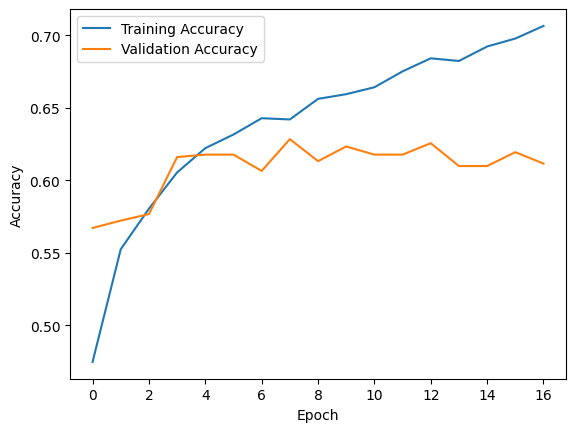

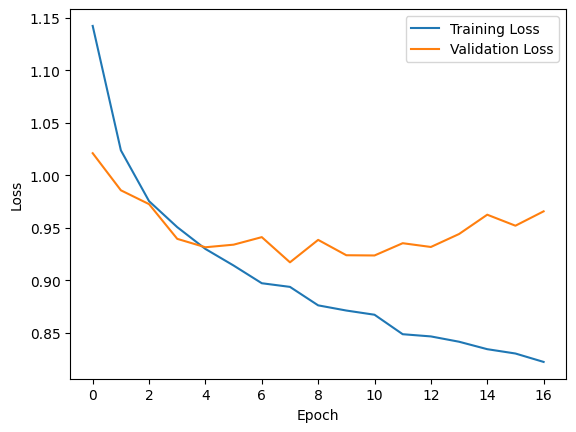

In [29]:
# Plot accuracy and loss
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [31]:
# Test accuracy
test_loss, test_accuracy = nn_model.evaluate(test_embeddings, test_labels)
print("Test Accuracy:", test_accuracy)

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.6266 - loss: 0.9112
Test Accuracy: 0.6335431933403015
